## Load the Data

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!ls -ls /content/gdrive/'My Drive'/wallahubTest

total 67317
67317 -rw------- 1 root root 68932570 May 20 16:07 dataset_00_with_header.csv


In [0]:
#Standar librarie
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statistics import mode
import matplotlib.lines as lines
from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm, skew

#bokeh libraires for visualizations
from bokeh.plotting import figure
from bokeh.io import output_file, show
from bokeh.io import output_notebook
from bokeh.plotting import figure
from bokeh.models.widgets import Panel, Tabs
from bokeh.plotting import ColumnDataSource
from bokeh.palettes import Spectral6
from bokeh.transform import factor_cmap

#machine learning librarires
from sklearn.linear_model import ElasticNet, Lasso, BayesianRidge, LassoLarsIC
from sklearn.feature_selection import f_regression
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
from joblib import dump, load

Load the file

In [0]:
df_ini = pd.read_csv("/content/gdrive/My Drive/wallahubTest/dataset_00_with_header.csv")
df_ini.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,x011,x012,x013,x014,x015,x016,x017,x018,x019,x020,x021,x022,x023,x024,x025,x026,x027,x028,x029,x030,x031,x032,x033,x034,x035,x036,x037,x038,x039,x040,...,x266,x267,x268,x269,x270,x271,x272,x273,x274,x275,x276,x277,x278,x279,x280,x281,x282,x283,x284,x285,x286,x287,x288,x289,x290,x291,x292,x293,x294,x295,x296,x297,x298,x299,x300,x301,x302,x303,x304,y
0,1540332,NaN,NaN,NaN,8.0,1,0,1,0,0,0,0,0,0,1,0,1,1,0,1,0,1,0,0,0,0,1,0,0,1,2,0,0,0,1,1,0,0,0,1,...,NaN,NaN,NaN,0,0,0,0.0000,0,0,NaN,0,0,0,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,0,NaN,0,0,0,0,NaN,0,NaN,706
1,823066,4.0,3.0,3.0,4.0,0,2,2,0,0,0,0,0,0,2,2,0,2,2,0,0,0,0,2,0,1,0,0,1,0,14,7,8,10,11,8,1,2,4,5,...,4.0,4.0,0.9256,1,1,1,0.9339,5206,0,NaN,0,0,0,5206,0,5206,1,1,1,2,0,1.0,4.0,3.0,3.5,5206,5206,0.9339,0,NaN,5206,0.9339,1,1,1,0,NaN,0,NaN,558
2,1089795,NaN,NaN,NaN,96.0,1,0,0,0,1,3,4,1,0,9,0,9,2,0,9,0,2,0,0,0,0,1,0,0,3,4,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,0,0,0,0.2281,1613,1613,0.4814,0,0,0,0,0,0,1,1,1,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,0,NaN,0,0,0,0,NaN,0,NaN,577
3,1147758,63.0,14.0,38.0,258.0,0,0,0,1,2,1,1,1,1,7,2,5,5,2,4,1,3,1,3,0,0,1,0,0,3,1,0,0,1,1,1,0,0,1,1,...,NaN,NaN,NaN,0,0,0,0.8204,62558,4796,1.1153,1,2,2,58218,58218,0,1,1,1,1,0,2.0,63.0,63.0,63.0,57762,57762,0.8231,57762,0.8231,0,NaN,1,1,1,0,NaN,0,NaN,526
4,1229670,34.0,25.0,29.0,34.0,1,0,0,0,3,0,0,0,0,3,2,1,2,1,3,2,2,1,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,0,0,...,NaN,NaN,NaN,0,0,0,0.1000,190,186,0.1430,1,1,1,190,190,0,1,1,1,0,0,NaN,NaN,NaN,NaN,0,0,NaN,0,NaN,0,NaN,0,0,0,0,NaN,0,NaN,496


In [0]:
def mem_usage(pandas_obj):
    '''functin to know the memory usage'''
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

In [0]:
df_ini.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 305 entries, x001 to y
dtypes: float64(41), int64(264)
memory usage: 232.7 MB


In [0]:
for dtype in ['float','int','object']:
    selected_dtype = df_ini.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 0.74 MB
Average memory usage for int columns: 0.76 MB
Average memory usage for object columns: 0.00 MB


Converting  some data types to reduce the memory usage

In [0]:
df_int = df_ini.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

df_float = df_ini.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

df = df_ini.copy()

df[converted_int.columns] = converted_int
df[converted_float.columns] = converted_float
print(mem_usage(df_ini))
print(mem_usage(df))

232.70 MB
49.31 MB


In [0]:
print(len(df_int.columns))
print(len(df_float.columns))

264
41


we reduce the memory usage  by 78%

## Exploratory Data Analysis

then I will fill the remain data with NA's with the median

### The output Variable

In [0]:
print(df['y'].describe())

count    100000.000000
mean        619.198230
std         118.461932
min         300.000000
25%         524.000000
50%         599.000000
75%         720.000000
max         839.000000
Name: y, dtype: float64


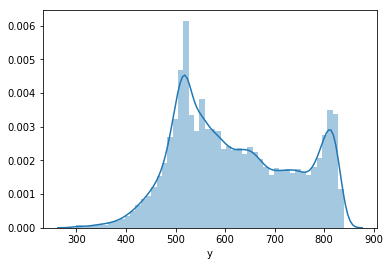

In [0]:
sns.distplot(df["y"])

we can see that we are facing a bimodal KDE, that is, this could mean that we are dealing with two types of populations or groups.

In [0]:
print("Skewness: %f" % df["y"].skew())
print("Kurtosis: %f" % df["y"].kurt())

Skewness: 0.222822
Kurtosis: -0.980317


The skewness it´s ok(the closest to zero the better) and the negative kurtosis indicates a "light tailed" distribution

In [0]:
percentiles = np.array([2.5, 25, 50, 75, 80, 97.5])
ptiles = np.percentile(df['y'].values, percentiles)
print(ptiles)

[425. 524. 599. 720. 748. 824.]


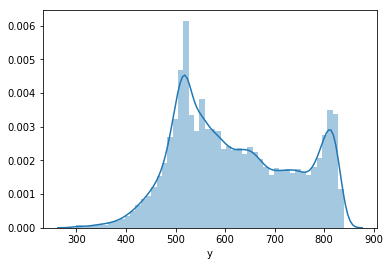

In [0]:
iqr = ptiles[3] - ptiles[1]
fence_low  = ptiles[1] - 1.5 * iqr
fence_high = ptiles[3] + 1.5 * iqr

train_df_no_outliers = df.loc[(df["y"] > fence_low) & (df["y"] < fence_high)]
y = train_df_no_outliers["y"]
sns.distplot(y)

In [0]:
len(df.index)-len(train_df_no_outliers.index)
fence_high, fence_low

(1014.0, 230.0)

so based in the interquartil range we do not have outlier values in the output variable y

## The Independ Variables

#### Missing Values

In [0]:
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
x242,93339,0.93339
x295,86533,0.86533
x304,81875,0.81875
x098,80681,0.80681
x155,79051,0.79051
x259,77432,0.77432
x255,76913,0.76913
x257,76913,0.76913
x256,76913,0.76913
x302,73069,0.73069


we have columns with a lot of NA's so I will drop all columns with more 0f 30% of Missing Values

In [0]:
sum(missing_data.Percent >0.3)

31

In [0]:
print(missing_data[missing_data.Percent> 0.3].index.tolist())

['x242', 'x295', 'x304', 'x098', 'x155', 'x259', 'x255', 'x257', 'x256', 'x302', 'x268', 'x162', 'x267', 'x266', 'x265', 'x253', 'x297', 'x275', 'x293', 'x288', 'x289', 'x290', 'x148', 'x223', 'x222', 'x058', 'x041', 'x057', 'x238', 'x237', 'x239']


I will dropping 31 columns

In [0]:
df.drop(missing_data[missing_data.Percent> 0.3].index.tolist(), axis=1, inplace=True)
df.shape

(100000, 274)

In [0]:
df.shape

(100000, 274)

Now we are gong to imputed the NA´s to the median or t the mode of the data

First, le't check some measures:

In [0]:

df_cat_stats = pd.DataFrame(columns = ['column', 'values', 'values_count_incna', 'values_count_nona', 
                                       'num_miss', 'pct_miss','median', 'most_common', 'num_most_common'])
df_tmp = pd.DataFrame()
for col in df.columns:
  df_tmp['column'] = [col]
  df_tmp['values'] = [df[col].unique()]
  df_tmp['values_count_incna'] = len(list(df[col].unique()))
  df_tmp['values_count_nona'] = int(df[col].nunique())
  df_tmp['num_miss'] = df[col].isnull().sum()
  df_tmp['pct_miss'] = (df[col].isnull().sum()/ len(df))*100
  df_tmp['median'] = df[col].median()
  df_tmp['most_common'] = df[col].mode()
  df_tmp['num_most_common'] = df[col].value_counts().max()
  df_cat_stats = df_cat_stats.append(df_tmp)

df_cat_stats.head(100)

,column,values,values_count_incna,values_count_nona,num_miss,pct_miss,median,most_common,num_most_common
0,x001,"[1540332, 823066, 1089795, 1147758, 1229670, 1...",100000,100000,0,0.000,1235926.0,517,1
0,x002,"[nan, 4.0, 63.0, 34.0, 53.0, 76.0, 23.0, 164.0...",667,666,21432,21.432,100.0,7,932
0,x003,"[nan, 3.0, 14.0, 25.0, 11.0, 7.0, 0.0, 18.0, 2...",458,457,21432,21.432,8.0,2,7066
0,x004,"[nan, 3.0, 38.0, 29.0, 27.0, 36.0, 9.0, 53.0, ...",493,492,21424,21.424,48.0,5,1343
0,x005,"[8.0, 4.0, 96.0, 258.0, 34.0, 126.0, 53.0, 107...",700,699,6110,6.110,150.0,120,585
0,x006,"[1, 0]",2,2,0,0.000,0.0,0,68596
0,x007,"[0, 2, 3, 1, 4, 8, 5, 7, 12, 6, 9, 10, 11, 20,...",32,32,0,0.000,0.0,0,63898
0,x008,"[1, 2, 0, 4, 3, 6, 10, 11, 5, 8, 14, 13, 7, 15...",44,44,0,0.000,1.0,0,46621
0,x009,"[0, 1, 3, 4, 2, 5, 13, 6, 8, 9, 11, 45, 7, 10,...",42,42,0,0.000,0.0,0,50814
0,x010,"[0, 1, 2, 3, 5, 17, 4, 7, 6, 9, 12, 8, 23, 10,...",30,30,0,0.000,0.0,0,54272


In [0]:
continuos_c = df_cat_stats[df_cat_stats.values_count_incna>=30].column.tolist()
categorical_c = df_cat_stats[df_cat_stats.values_count_incna<30].column.tolist()
one_value_c = df_cat_stats[df_cat_stats.values_count_incna==1].column.tolist()

In [0]:
print(continuos_c)

['x001', 'x002', 'x003', 'x004', 'x005', 'x007', 'x008', 'x009', 'x010', 'x011', 'x012', 'x013', 'x014', 'x015', 'x016', 'x017', 'x020', 'x021', 'x024', 'x028', 'x029', 'x030', 'x031', 'x033', 'x034', 'x035', 'x036', 'x042', 'x043', 'x044', 'x045', 'x059', 'x063', 'x064', 'x065', 'x066', 'x072', 'x073', 'x074', 'x075', 'x076', 'x106', 'x111', 'x114', 'x115', 'x116', 'x117', 'x118', 'x119', 'x120', 'x121', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x133', 'x134', 'x135', 'x136', 'x137', 'x138', 'x139', 'x140', 'x141', 'x142', 'x143', 'x144', 'x145', 'x146', 'x151', 'x152', 'x153', 'x158', 'x159', 'x160', 'x165', 'x166', 'x167', 'x181', 'x185', 'x186', 'x188', 'x189', 'x190', 'x191', 'x192', 'x193', 'x194', 'x195', 'x196', 'x199', 'x200', 'x201', 'x202', 'x203', 'x204', 'x205', 'x206', 'x208', 'x209', 'x210', 'x211', 'x212', 'x213', 'x214', 'x215', 'x216', 'x217', 'x218', 'x219', 'x220', 'x221', 'x224', 'x231', 'x232', 'x233', 'x234', 'x235', 'x236', 'x240', 'x243', 'x250',

In [0]:
print(categorical_c)

['x006', 'x018', 'x019', 'x022', 'x023', 'x025', 'x026', 'x027', 'x032', 'x037', 'x038', 'x039', 'x040', 'x046', 'x047', 'x048', 'x049', 'x050', 'x051', 'x052', 'x053', 'x054', 'x055', 'x056', 'x060', 'x061', 'x062', 'x067', 'x068', 'x069', 'x070', 'x071', 'x077', 'x078', 'x079', 'x080', 'x081', 'x082', 'x083', 'x084', 'x085', 'x086', 'x087', 'x088', 'x089', 'x090', 'x091', 'x092', 'x093', 'x094', 'x095', 'x096', 'x097', 'x099', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x107', 'x108', 'x109', 'x110', 'x112', 'x113', 'x122', 'x123', 'x124', 'x132', 'x147', 'x149', 'x150', 'x154', 'x156', 'x157', 'x161', 'x163', 'x164', 'x168', 'x169', 'x170', 'x171', 'x172', 'x173', 'x174', 'x175', 'x176', 'x177', 'x178', 'x179', 'x180', 'x182', 'x183', 'x184', 'x187', 'x197', 'x198', 'x207', 'x225', 'x226', 'x227', 'x228', 'x229', 'x230', 'x241', 'x244', 'x245', 'x246', 'x247', 'x248', 'x249', 'x251', 'x252', 'x254', 'x260', 'x261', 'x262', 'x263', 'x269', 'x270', 'x271', 'x276', 'x277', 'x282',

In [0]:
print(one_value_c)

['x067', 'x094', 'x095', 'x096']


There are categorical, binaries and continuos columns, and I seem that the first columns *x001* is un id column, so we are to delete it

We are imputing the values if categorical to the mode another case to the median

In [0]:

imr_continuos = SimpleImputer(missing_values=np.nan, strategy='median')
df[continuos_c]= imr_continuos.fit_transform(df[continuos_c])
imr_categorical = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
df[categorical_c]= imr_categorical.fit_transform(df[categorical_c])
df.head()

,x001,x002,x003,x004,x005,x006,x007,x008,x009,x010,x011,x012,x013,x014,x015,x016,x017,x018,x019,x020,x021,x022,x023,x024,x025,x026,x027,x028,x029,x030,x031,x032,x033,x034,x035,x036,x037,x038,x039,x040,...,x248,x249,x250,x251,x252,x254,x258,x260,x261,x262,x263,x264,x269,x270,x271,x272,x273,x274,x276,x277,x278,x279,x280,x281,x282,x283,x284,x285,x286,x287,x291,x292,x294,x296,x298,x299,x300,x301,x303,y
0,1540332.0,100.0,8.0,48.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,706.0
1,823066.0,4.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,14.0,7.0,8.0,10.0,11.0,8.0,1.0,2.0,4.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4582.0,1.0,1.0,1.0,0.9339,5206.0,0.0,0.0,0.0,0.0,5206.0,0.0,5206.0,1.0,1.0,1.0,2.0,0.0,1.0,5206.0,5206.0,0.0,5206.0,1.0,1.0,1.0,0.0,0.0,558.0
2,1089795.0,100.0,8.0,48.0,96.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,0.0,9.0,0.0,9.0,2.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2281,1613.0,1613.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,577.0
3,1147758.0,63.0,14.0,38.0,258.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,7.0,2.0,5.0,5.0,2.0,4.0,1.0,3.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,...,0.0,1.0,1.0,1.0,0.0,1.0,57762.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8204,62558.0,4796.0,1.0,2.0,2.0,58218.0,58218.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,57762.0,57762.0,57762.0,0.0,1.0,1.0,1.0,0.0,0.0,526.0
4,1229670.0,34.0,25.0,29.0,34.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1000,190.0,186.0,1.0,1.0,1.0,190.0,190.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0


In [0]:
total = df.isnull().sum().sort_values(ascending=False)
sum(total)


0

Now, we do not have missing values

Now we can crop some useless columns like *x001, x067, x094, x095, x096*

In [0]:
df.drop(['x001'], axis= 1, inplace=True)

In [0]:
df.drop(one_value_c, axis= 1, inplace=True)

and Delete duplicate columns and row if any:

In [0]:
df.T.drop_duplicates().T
df.drop_duplicates()
df.head()

,x002,x003,x004,x005,x006,x007,x008,x009,x010,x011,x012,x013,x014,x015,x016,x017,x018,x019,x020,x021,x022,x023,x024,x025,x026,x027,x028,x029,x030,x031,x032,x033,x034,x035,x036,x037,x038,x039,x040,x042,...,x248,x249,x250,x251,x252,x254,x258,x260,x261,x262,x263,x264,x269,x270,x271,x272,x273,x274,x276,x277,x278,x279,x280,x281,x282,x283,x284,x285,x286,x287,x291,x292,x294,x296,x298,x299,x300,x301,x303,y
0,100.0,8.0,48.0,8.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,706.0
1,4.0,3.0,3.0,4.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,1.0,0.0,14.0,7.0,8.0,10.0,11.0,8.0,1.0,2.0,4.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,4582.0,1.0,1.0,1.0,0.9339,5206.0,0.0,0.0,0.0,0.0,5206.0,0.0,5206.0,1.0,1.0,1.0,2.0,0.0,1.0,5206.0,5206.0,0.0,5206.0,1.0,1.0,1.0,0.0,0.0,558.0
2,100.0,8.0,48.0,96.0,1.0,0.0,0.0,0.0,1.0,3.0,4.0,1.0,0.0,9.0,0.0,9.0,2.0,0.0,9.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,4.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2281,1613.0,1613.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,577.0
3,63.0,14.0,38.0,258.0,0.0,0.0,0.0,1.0,2.0,1.0,1.0,1.0,1.0,7.0,2.0,5.0,5.0,2.0,4.0,1.0,3.0,1.0,3.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,300.0,...,0.0,1.0,1.0,1.0,0.0,1.0,57762.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.8204,62558.0,4796.0,1.0,2.0,2.0,58218.0,58218.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,57762.0,57762.0,57762.0,0.0,1.0,1.0,1.0,0.0,0.0,526.0
4,34.0,25.0,29.0,34.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,3.0,2.0,1.0,2.0,1.0,3.0,2.0,2.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,900.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1000,190.0,186.0,1.0,1.0,1.0,190.0,190.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,496.0


## Check the Correlation 

target vs independent variables

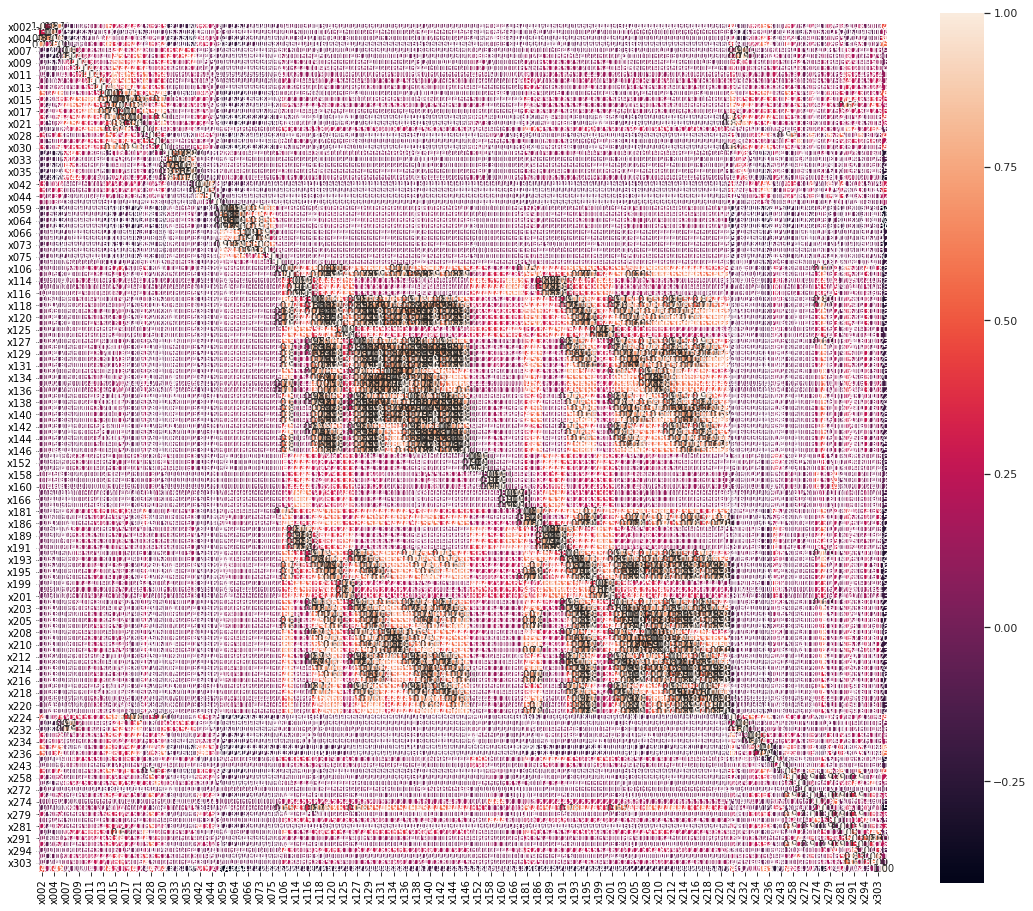

In [0]:
continuos_c.pop(0)
corr_matrix =df[continuos_c].corr()
f, ax = plt.subplots(figsize=(19, 16))
sns.set(font_scale=1.0)
hm = sns.heatmap(corr_matrix, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

In [0]:
corr_matrix =df.corr()
corr_matrix["y"].sort_values(ascending=False)

y       1.000000
x235    0.614262
x005    0.572926
x236    0.572875
x022    0.568884
x227    0.537190
x249    0.515316
x226    0.514055
x228    0.512067
x046    0.507595
x244    0.503321
x225    0.488159
x025    0.487376
x023    0.480639
x014    0.474342
x002    0.468960
x245    0.467735
x246    0.459512
x250    0.447270
x247    0.446191
x262    0.445821
x229    0.443279
x261    0.439065
x260    0.434920
x224    0.432531
x030    0.425470
x027    0.424206
x004    0.418185
x020    0.415688
x028    0.414760
          ...   
x106   -0.257499
x181   -0.258218
x194   -0.259715
x075   -0.260677
x147   -0.261755
x112   -0.262335
x104   -0.263943
x187   -0.264343
x240   -0.264705
x193   -0.270021
x192   -0.279946
x031   -0.280099
x171   -0.283763
x073   -0.284965
x040   -0.291714
x062   -0.293974
x276   -0.307428
x099   -0.307428
x277   -0.308842
x172   -0.309105
x036   -0.312055
x278   -0.316596
x056   -0.336567
x173   -0.337363
x168   -0.348083
x063   -0.358450
x064   -0.411101
x065   -0.4138

Some variables have average correlation coefficients, which indicates that they could be useful for models

## Training the Models

#### split train- test

In [0]:

X_train, X_test, y_train, y_test = train_test_split( df.drop(['y'], axis=1), df['y'] , test_size=0.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((80000, 268), (20000, 268), (80000,), (20000,))

The next step we will do is apply the linear model f_regression of sklearn, to test the individual effect of each of the different regressors. It is a function that is used as a procedure for the selection of characteristics. The function  calculates the correlation between each regressor and the "target" is calculated, converted to an "F-score" and then to a "p-value".

In this way we obtain the F-score and p-value statistics of each predictor with respect to the target

In [0]:
[F, pval] = f_regression(X_train, y_train, center = True)
f_selection = np.vstack((list(X_train),F, pval)).T
f_selection_df = pd.DataFrame(data=f_selection, index=np.arange(len(F)), columns=['name','F-score', 'p-value'])
f_selection_df.sort_values('p-value', ascending = False)

,name,F-score,p-value
9,x011,1030.7986027654142,9.827911993326829e-225
240,x264,1096.1272034224546,9.538932384965457e-239
132,x142,1488.9088770554977,9.4e-323
147,x159,358.38726034438827,9.452075963643998e-80
22,x024,289.45536790834655,8.50058971465419e-65
259,x291,165.54540844636503,7.581563802849547e-38
246,x274,1447.2939541014105,7.2179962946e-314
49,x052,74.22055701089573,7.110406671161974e-18
10,x012,1101.475024014238,6.806579724134944e-240
84,x090,419.05275879018075,6.79612457102034e-93


In [0]:
highp_c = f_selection_df[f_selection_df['p-value'].astype('float64')> 0.05].name
highp_c

7      x009
55     x060
217    x232
Name: name, dtype: object

In [0]:
f_selection_df[f_selection_df['name']== 'x009']

,name,F-score,p-value
7,x009,0.6164040197918603,0.43238904707899983


we decide to delete columns with p-value greater than 0.05, the columns *x009, x060, x232*
Because the predictors with high p-value indicate that they are not statistically significant, i.e they are not relevant for the regression model.

In [0]:
X_train.drop(highp_c, axis= 1, inplace=True)

In [0]:
X_test.drop(highp_c, axis= 1, inplace=True)

Lasso Regression

In [0]:
from sklearn.metrics import mean_squared_error
from math import sqrt





def rmsle_cv(model):
    '''
    helper function to return the rmse of the model with cross validation 
    '''
    cv=2
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = cv))
    return(rmse)
  
  
  
def accuracy_metric(y_true, y_pred):
    ''' This return 
      the accuracy: If the absolute error of a  prediction is greater than 3.0, we regard the prediction as "wrong". Otherwise, it is "correct".
      the number of correct predictions
      the rmse
    '''
    val_abs = np.abs(y_true- y_pred)
    corrects_pred = sum([1 if x < 3 else 0 for x in val_abs ])
    accy = corrects_pred/len(val_abs)
    rms = sqrt(mean_squared_error(y_true, y_pred))
    return accy*100, rms, corrects_pred

In [0]:
lasso_clf = Pipeline([("rs", RobustScaler()), ("clf",Lasso(random_state=5, alpha=0.01, max_iter=5000))])

score = rmsle_cv(lasso_clf)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Lasso score: 51.2729 (0.4441)



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [0]:
lasso_clf.fit(X_train, y_train)
pred = lasso_clf.predict(X_test)
accuracy_metric(y_test, pred)


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


(5.18, 50.08983679967342, 1036)

Gradient Boosting Regression

In [0]:
model_gb = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=7, max_features='sqrt',
                                   min_samples_leaf=25, min_samples_split=10, 
                                   loss='huber', random_state =5)


score = rmsle_cv(model_gb)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 26.1106 (0.0577)



In [0]:
model_gb.fit(X_train, y_train)
pred = model_gb.predict(X_test)
accuracy_metric(y_test, pred)


(15.915000000000001, 25.459075945467465, 3183)

Light GBM

In [44]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=10,
                              learning_rate=0.05, n_estimators=3100,
                              max_bin = 80, bagging_fraction = 0.9,
                              bagging_freq = 5, feature_fraction = 0.5,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11, verbose = -1)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 26.5957 (0.0627)



In [0]:
model_lgb.fit(X_train, y_train)
pred = model_lgb.predict(X_test)
accuracy_metric(y_test, pred)


(13.375, 26.265637966658446, 2675)

XGBoosting

In [0]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=9, 
                             min_child_weight=8, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1, nthread = -1)

score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Xgboost score: 26.4031 (0.0250)



In [0]:
model_xgb.fit(X_train, y_train)
pred = model_xgb.predict(X_test)
accuracy_metric(y_test, pred)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(17.25, 25.406824890672628, 3450)

Stacking Models

In [0]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    #the models
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # train the base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # to predict
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

In [0]:
averaged_models = AveragingModels(models = (model_lgb, model_gb, model_xgb))

score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Averaged base models score: 25.6601 (0.0506)



In [0]:
averaged_models.fit(X_train, y_train)
pred = averaged_models.predict(X_test)
accuracy_metric(y_test, pred)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(15.915000000000001, 25.02546254590766, 3183)

Stacking meta Models

In [0]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=3):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # fitting
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # train and create meta-predictions
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X.iloc[train_index], y.iloc[train_index])
                y_pred = instance.predict(X.iloc[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
            
        # now traing the meta model with the meta predictions
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #to predict
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [103]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_lgb, model_gb),
                                                 meta_model = model_xgb)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Stacking Averaged models score: 27.6142 (0.1305)


In [104]:
stacked_averaged_models.fit(X_train, y_train)
pred = stacked_averaged_models.predict(X_test)
accuracy_metric(y_test, pred)


/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


(14.025000000000002, 26.68707978736492, 2805)

#### For simplicity we will select the xgboost as our model, and we will build the pipeline with all data 

## Build the Pipeline

In [0]:

from sklearn.base import TransformerMixin
import numpy as np
import pandas as pd
import time
import sys
import argparse



  
class CleanerData(TransformerMixin):
  def __init__(self):
      self.imr_continuos = SimpleImputer(missing_values=np.nan, strategy='median')
      self.imr_categorical = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
      self.columns_to_del = ['x067', 'x094', 'x095', 'x096', 'x001', 'x009', 'x060', 'x232', \
                            'x242', 'x295', 'x304', 'x098', 'x155', 'x259', 'x255', 'x257', 'x256', 'x302', 'x268', 'x162', 'x267', 'x266', 'x265',\
                             'x253', 'x297', 'x275', 'x293', 'x288', 'x289', 'x290', 'x148', 'x223', 'x222', 'x058', 'x041', 'x057', 'x238', 'x237', 'x239']
      self.columns_cont = [ 'x002', 'x003', 'x004', 'x005', 'x007', 'x008', 'x010', 'x011', 'x012', 'x013', 'x014', 'x015', 'x016', 'x017',\
                           'x020', 'x021', 'x024', 'x028', 'x029', 'x030', 'x031', 'x033', 'x034', 'x035', 'x036', 'x042', 'x043', 'x044', 'x045', 'x059',\
                           'x063', 'x064', 'x065', 'x066', 'x072', 'x073', 'x074', 'x075', 'x076', 'x106', 'x111', 'x114', 'x115', 'x116', 'x117', 'x118', \
                           'x119', 'x120', 'x121', 'x125', 'x126', 'x127', 'x128', 'x129', 'x130', 'x131', 'x133', 'x134', 'x135', 'x136', 'x137', 'x138',\
                           'x139', 'x140', 'x141', 'x142', 'x143', 'x144', 'x145', 'x146', 'x151', 'x152', 'x153', 'x158', 'x159', 'x160', 'x165', 'x166', \
                           'x167', 'x181', 'x185', 'x186', 'x188', 'x189', 'x190', 'x191', 'x192', 'x193', 'x194', 'x195', 'x196', 'x199', 'x200', 'x201', \
                           'x202', 'x203', 'x204', 'x205', 'x206', 'x208', 'x209', 'x210', 'x211', 'x212', 'x213', 'x214', 'x215', 'x216', 'x217', 'x218', \
                           'x219', 'x220', 'x221', 'x224', 'x231', 'x233', 'x234', 'x235', 'x236', 'x240', 'x243', 'x250', 'x258', 'x264', 'x272',\
                           'x273', 'x274', 'x278', 'x279', 'x280', 'x281', 'x285', 'x291', 'x292', 'x294', 'x296', 'x303']

      self.columns_cat = ['x006', 'x018', 'x019', 'x022', 'x023', 'x025', 'x026', 'x027', 'x032', 'x037', 'x038', 'x039', 'x040', 'x046', 'x047', 'x048',\
                          'x049', 'x050', 'x051', 'x052', 'x053', 'x054', 'x055', 'x056', 'x061', 'x062', 'x068', 'x069', 'x070', 'x071',\
                          'x077', 'x078', 'x079', 'x080', 'x081', 'x082', 'x083', 'x084', 'x085', 'x086', 'x087', 'x088', 'x089', 'x090', 'x091', 'x092', \
                          'x093', 'x097', 'x099', 'x100', 'x101', 'x102', 'x103', 'x104', 'x105', 'x107', 'x108', 'x109', 'x110',\
                          'x112', 'x113', 'x122', 'x123', 'x124', 'x132', 'x147', 'x149', 'x150', 'x154', 'x156', 'x157', 'x161', 'x163', 'x164', 'x168', \
                          'x169', 'x170', 'x171', 'x172', 'x173', 'x174', 'x175', 'x176', 'x177', 'x178', 'x179', 'x180', 'x182', 'x183', 'x184', 'x187',\
                          'x197', 'x198', 'x207', 'x225', 'x226', 'x227', 'x228', 'x229', 'x230', 'x241', 'x244', 'x245', 'x246', 'x247', 'x248', 'x249', \
                          'x251', 'x252', 'x254', 'x260', 'x261', 'x262', 'x263', 'x269', 'x270', 'x271', 'x276', 'x277', 'x282', 'x283', 'x284', 'x286',\
                          'x287', 'x298', 'x299', 'x300', 'x301']

  def preprocess_x(self, x):
      x = x.copy() 
      df_int = x.select_dtypes(include=['int']).columns
      x[df_int]= x[df_int].apply(pd.to_numeric,downcast='unsigned')
      df_float = x.select_dtypes(include=['float']).columns
      x[df_float]= x[df_float].apply(pd.to_numeric,downcast='float')
      x.drop(self.columns_to_del, axis=1, inplace=True)
      x[self.columns_cont]= self.imr_continuos.fit_transform(x[self.columns_cont])
      x[self.columns_cat]= self.imr_categorical.fit_transform(x[self.columns_cat])
      x.T.drop_duplicates().T
      x.drop_duplicates()
      return x

  def fit(self, x, y=None):
      return self

  def transform(self, x, y=None):
      x = self.preprocess_x(x)
      return x


cleaner = CleanerData()

df_ini = pd.read_csv("/content/gdrive/My Drive/wallahubTest/dataset_00_with_header.csv")

pipeline = Pipeline([('clr',cleaner), ('clf',model_xgb)])
pipeline.fit(df_ini.drop(['y'], axis=1), df_ini['y'])
predictions = pipeline.predict(df_ini.drop(['y'], axis=1))
acc, rmse, _ =accuracy_metric(df_ini['y'], predictions)

print("the metrics of the models are RMSE: {:.4f},  Accuracy: {:.4f}".format(rmse, acc))


        
        


## Export the model

In [106]:
dump(pipeline, 'pipeline.pkl', compress = 1)

['pipeline.pkl']